<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Comparing DBSCAN and HDBSCAN clustering 
Estimated time needed: **30** minutes
    

## Objectives


After completing this lab, you will be able to:

* Use scikit-learn to implement DBSCAN and HDBSCAN clustering models to real data
* Compare the performances of the two models 



## Introduction
In this lab, you'll create two clustering models using data curated by StatCan containing the names, types, and locations of
cultural and art facilities across Canada.
We'll focus on the museum locations provided across Canada.

#### Data source: The Open Database of Cultural and Art Facilities (ODCAF)

A collection of open data containing the names, types, and locations of cultural and art facilities across Canada. 
It is released under the Open Government License - Canada.
The different types of facilities are labeled under 'ODCAF_Facility_Type'.

#### Landing page:
https://www.statcan.gc.ca/en/lode/databases/odcaf

#### link to zip file:
https://www150.statcan.gc.ca/n1/en/pub/21-26-0001/2020001/ODCAF_V1.0.zip?st=brOCT3Ry


## Import the required libraries


In [1]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install hdbscan==0.8.40
!pip install geopandas==1.0.1
!pip install contextily==1.6.2
!pip install shapely==2.0.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 133.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 152.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 170.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 151.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 178.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.5/32.5 MB 14.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 10.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

# geographical tools
import geopandas as gpd  # pandas dataframe-like geodataframes for geographical data
import contextily as ctx  # used for obtianing a basemap of Canada
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

## Download the Canada map for reference

To get a proper context of the final output of this lab, you need a reference map of Canada. Execute the cell below to extract the same to this lab environment.


In [3]:
import requests
import zipfile
import io
import os

# URL of the ZIP file on the cloud server
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'

# Directory to save the extracted TIFF file
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Download the ZIP file
response = requests.get(zip_file_url)
response.raise_for_status()  # Ensure the request was successful
# Step 2: Open the ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # Step 3: Iterate over the files in the ZIP
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):  # Check if it's a TIFF file
            # Step 4: Extract the TIFF file
            zip_ref.extract(file_name, output_dir)
            print(f"Downloaded and extracted: {file_name}")

Downloaded and extracted: Canada.tif


## Include a plotting function
The code for a helper function is provided to help you plot your results. Although you don't need to worry about the details, it's quite instructive as it uses a geopandas dataframe and a basemap to plot coloured cluster points on a map of Canada.


In [12]:
# Write a function that plots clustered locations and overlays them on a basemap.

def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.
    
    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """
    
    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")
    
    # Reproject to Web Mercator to align with basemap 
    gdf = gdf.to_crs(epsg=3857)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]
    
    # Plot noise points 
    noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')
    
    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)
    
    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)
    
    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    
    # Show the plot
    plt.show()

## Explore the data and extract what you need from it


#### Start by loading the data set into a Pandas DataFrame and displaying the first few rows.


In [5]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")

In [6]:
df.head()

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766


### Exercise 1. Explore the table. What do missing values look like in this data set?


<details><summary>Click here for the solution</summary>
Strings consisting of two dots '..' indicate missing values. There miight still be empty fields, or NaNs.
</details>


### Exercise 2. Display the facility types and their counts.


In [17]:
# your code here
df.ODCAF_Facility_Type.value_counts()


AttributeError: 'DataFrame' object has no attribute 'ODCAF_Facility_Type'

<details><summary>Click here for the solution</summary>
    
```python
df.ODCAF_Facility_Type.value_counts()
```

</details>


### Exercise 3. Filter the data to only include museums.
Check your results. Did you get as many as you expected?


In [18]:
# your code here
df = df[df.ODCAF_Facility_Type == 'museum']
df.ODCAF_Facility_Type.value_counts()

AttributeError: 'DataFrame' object has no attribute 'ODCAF_Facility_Type'

<details><summary>Click here for the solution</summary>

```python
df = df[df.ODCAF_Facility_Type == 'museum']
df.ODCAF_Facility_Type.value_counts()
```

</details>


### Exercise 4.  Select only the Latitude and Longitude features as inputs to our clustering problem.
Also, display information about the coordinates like counts and data types.


In [19]:
# your code here
df = df[['Latitude', 'Longitude']]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


<details><summary>Click here for the solution</summary>

```python
df = df[['Latitude', 'Longitude']]
df.info()
```

</details>


### Exercise 5. We'll need these coordinates to be floats, not objects.
Remove any museums that don't have coordinates, and convert the remaining coordinates to floats.


In [20]:
# your code here
# Remove observations with no coordinates 
df = df[df.Latitude!='..']

# Convert to float
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype('float')

<details><summary>Click here for the solution</summary>

```python

# Remove observations with no coordinates 
df = df[df.Latitude!='..']

# Convert to float
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype('float')
```

</details>


## Build a DBSCAN model
##### Correctly scale the coordinates for DBSCAN (since DBSCAN is sensitive to scale)


In [21]:
# In this case we know how to scale the coordinates. Using standardization would be an error becaues we aren't using the full range of the lat/lng coordinates.
# Since latitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees, the correct scaling is to double the longitude coordinates (or half the Latitudes)
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

### Apply DBSCAN with Euclidean distance to the scaled coordinates
In this case, reasonable neighbourhood parameters are already chosen for you. Feel free to experiment.


In [22]:
min_samples=3 # minimum number of samples needed to form a neighbourhood
eps=1.0 # neighbourhood search radius
metric='euclidean' # distance measure 

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(coords_scaled)

### Add cluster labels to the DataFrame


In [11]:
df['Cluster'] = dbscan.fit_predict(coords_scaled)  # Assign the cluster labels

# Display the size of each cluster
df['Cluster'].value_counts()

NameError: name 'dbscan' is not defined

As you can see, there are two relatively large clusters and 79 points labelled as noise (-1).
### Plot the museums on a basemap of Canada, colored by cluster label.


KeyError: 'Cluster'

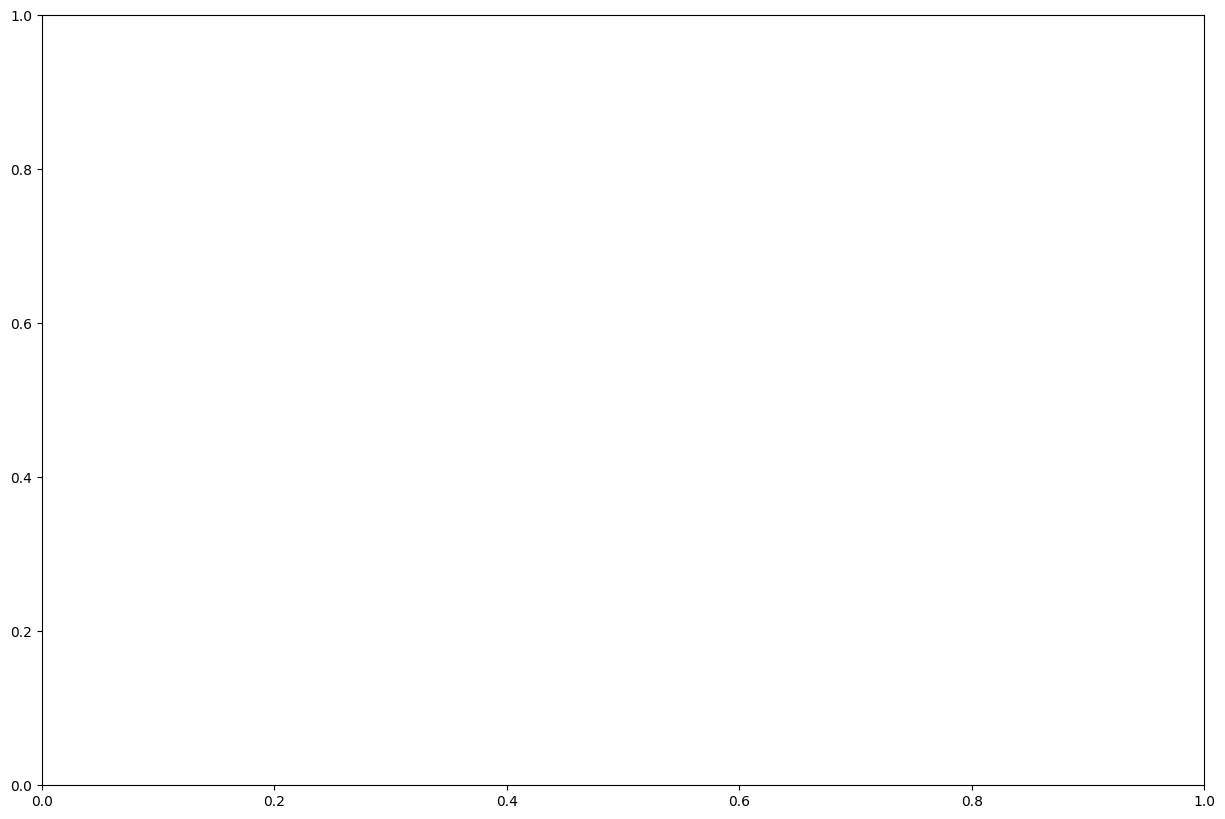

In [23]:
plot_clustered_locations(df, title='Museums Clustered by Proximity')

- What do you see? 
- What size is the smallest cluster? 
- Do you think the clusters make sense in terms of what you expect to see? 
- Do you think there should be more clusters in some regions? Why?


One key thing to notice here is that the clusters are not uniformly dense. 

For example, the points are quite densely packed in a few regions but are relatively sparse in between. 

DBSCAN agglomerates neighboring clusters together when they are close enough. 

Let's see how a hierarchical density-based clustering algorithm like HDBSCAN performs.


## Build an HDBSCAN clustering model
At this stage, you've already loaded your data and extracted the museum coordinates into a dataframe, df.

You've also stored properly scaled coordinates as the 'coords_scaled' array.

All that remains is to:
- Fit and transform HDBSCAN to your scaled coordinates
- Extract the cluster labels
- Plot the results on the same basemap as before

Reasonable HDBSCAN parameters have been selected for you to start with.


#### Initialize an HDBSCAN model


In [24]:
min_samples=None
min_cluster_size=3
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='euclidean')  # You can adjust parameters as needed

### Exercise 6. Assign the cluster labels to your unscaled coordinate dataframe and display the counts of each cluster label.


In [25]:
# Enter code here:

# Assign labels
df['Cluster'] = hdb.fit_predict(...)  # Another way to assign the labels

# Display the size of each cluster
df['Cluster']....()

SyntaxError: invalid syntax (3540502505.py, line 7)

<details><summary>Click here for the solution</summary>

```python
# Assign labels
df['Cluster'] = hdb.fit_predict(coords_scaled)  # Another way to assign the labels

# Display the size of each cluster
df['Cluster'].value_counts()
```


As you can see, unlike the case for DBSCAN, clusters quite uniformly sized, although there is a quite lot of noise identified.
### Exercise 7. Plot the hierarchically clustered museums on a basemap of Canada, colored by cluster label.


In [26]:
# Plot the museum clusters
...(..., title='Museums Hierarchically Clustered by Proximity')

TypeError: 'ellipsis' object is not callable

<details><summary>Click here for the solution</summary>
    
```python
# Plot the museum clusters
plot_clustered_locations(df, title='Museums Hierarchically Clustered by Proximity')
```


### Closing remarks


Take a close look at the map. 
- What's different about these results compared to DBSCAN?
- It might seem like there are more points identified as noise, but is that the case?
- Can you see the variations in density that HDBSCAN captures?
- In practice, you would want to investigate much deeper but at least you get the idea here.


## Summary
Congratulations! You're ready to move on to your next lesson! In this lab, you learned how to implement DBSCAN and HDBSCAN clustering models using scikit-learn on real data from StatCan, focusing on museum locations across Canada. You also compared the performance of the two clustering techniques.

## Author

<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>


### Other Contributors

<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" target="_blank">Abhishek Gagneja</a>


<!-- ## Changelog

| Date | Version | Changed by | Change Description |
|:------------|:------|:------------------|:---------------------------------------|
| 2024-11-05 | 1.0  | Jeff Grossman    | Update content and practice exercises |
 -->


## <h3 align="center"> © IBM Corporation. All rights reserved. <h3/>


